**Introduction to Artificial Neural Networks with Keras**


# Setup

First, let's import a few common modules, ensure MatplotLib plots figures inline and prepare a function to save the figures. We also check that Python 3.5 or later is installed (although Python 2.x may work, it is deprecated so we strongly recommend you use Python 3 instead), as well as Scikit-Learn ≥0.20 and TensorFlow ≥2.0-preview.

In [ ]:
# Python ≥3.5 is required
import sys

assert sys.version_info >= (3, 7)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# TensorFlow ≥2.8 is required
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Perceptrons

In [ ]:
import numpy as np
from sklearn.datasets import load_iris
from sklearn.linear_model import Perceptron

iris = load_iris()
X = iris.data[:, (2, 3)]  # petal length, petal width
y = (iris.target == 0)

per_clf = Perceptron(max_iter=1000, tol=1e-3, random_state=42)
per_clf.fit(X, y)

y_pred = per_clf.predict([[2, 0.5]])

In [ ]:
y_pred

array([ True])

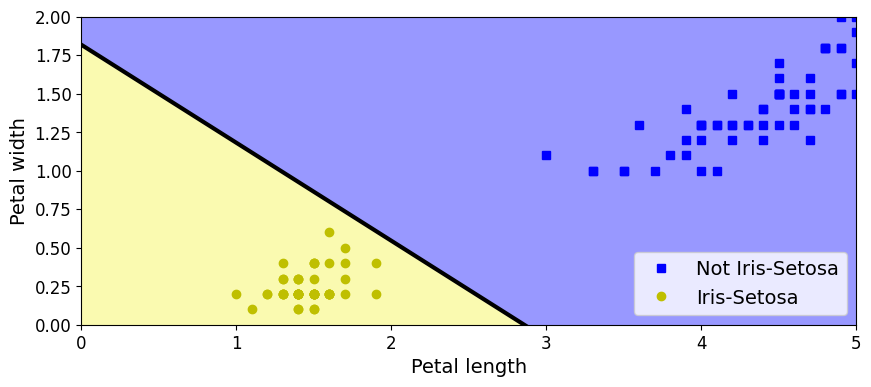

In [ ]:
a = -per_clf.coef_[0][0] / per_clf.coef_[0][1]
b = -per_clf.intercept_ / per_clf.coef_[0][1]

axes = [0, 5, 0, 2]

x0, x1 = np.meshgrid(
        np.linspace(axes[0], axes[1], 500).reshape(-1, 1),
        np.linspace(axes[2], axes[3], 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]
y_predict = per_clf.predict(X_new)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="Not Iris-Setosa")
plt.plot(X[y==1, 0], X[y==1, 1], "yo", label="Iris-Setosa")

plt.plot([axes[0], axes[1]], [a * axes[0] + b, a * axes[1] + b], "k-", linewidth=3)
from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#9898ff', '#fafab0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="lower right", fontsize=14)
plt.axis(axes)

plt.show()

# Activation functions

In [ ]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

def relu(z):
    return np.maximum(0, z)

def derivative(f, z, eps=0.000001):
    return (f(z + eps) - f(z - eps))/(2 * eps)

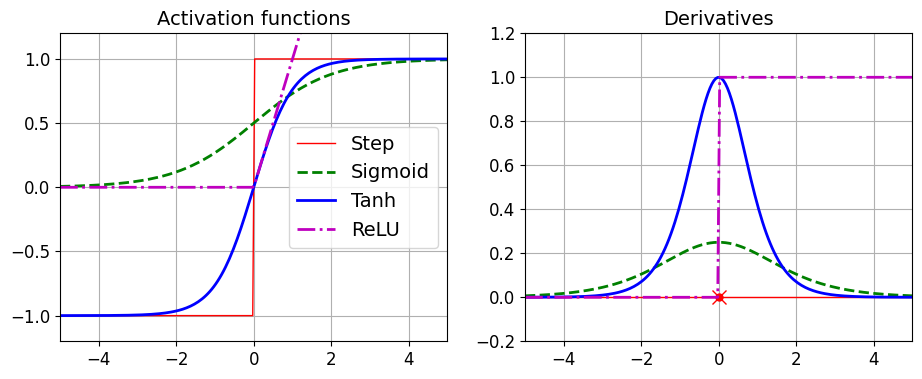

In [ ]:
z = np.linspace(-5, 5, 200)

plt.figure(figsize=(11,4))

plt.subplot(121)
plt.plot(z, np.sign(z), "r-", linewidth=1, label="Step")
plt.plot(z, sigmoid(z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, np.tanh(z), "b-", linewidth=2, label="Tanh")
plt.plot(z, relu(z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
plt.legend(loc="center right", fontsize=14)
plt.title("Activation functions", fontsize=14)
plt.axis([-5, 5, -1.2, 1.2])

plt.subplot(122)
plt.plot(z, derivative(np.sign, z), "r-", linewidth=1, label="Step")
plt.plot(0, 0, "ro", markersize=5)
plt.plot(0, 0, "rx", markersize=10)
plt.plot(z, derivative(sigmoid, z), "g--", linewidth=2, label="Sigmoid")
plt.plot(z, derivative(np.tanh, z), "b-", linewidth=2, label="Tanh")
plt.plot(z, derivative(relu, z), "m-.", linewidth=2, label="ReLU")
plt.grid(True)
#plt.legend(loc="center right", fontsize=14)
plt.title("Derivatives", fontsize=14)
plt.axis([-5, 5, -0.2, 1.2])


plt.show()

In [ ]:
def heaviside(z):
    return (z >= 0).astype(z.dtype)

def mlp_xor(x1, x2, activation=heaviside):
    return activation(-activation(x1 + x2 - 1.5) + activation(x1 + x2 - 0.5) - 0.5)

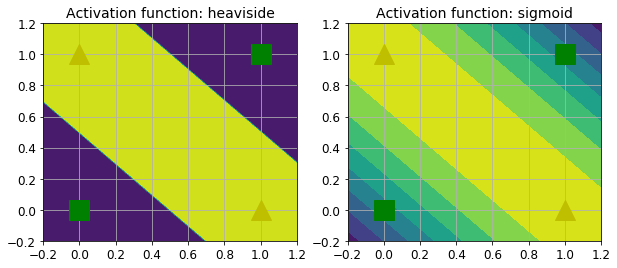

In [ ]:
x1s = np.linspace(-0.2, 1.2, 100)
x2s = np.linspace(-0.2, 1.2, 100)
x1, x2 = np.meshgrid(x1s, x2s)

z1 = mlp_xor(x1, x2, activation=heaviside)
z2 = mlp_xor(x1, x2, activation=sigmoid)

plt.figure(figsize=(10,4))

plt.subplot(121)
plt.contourf(x1, x2, z1)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: heaviside", fontsize=14)
plt.grid(True)

plt.subplot(122)
plt.contourf(x1, x2, z2)
plt.plot([0, 1], [0, 1], "gs", markersize=20)
plt.plot([0, 1], [1, 0], "y^", markersize=20)
plt.title("Activation function: sigmoid", fontsize=14)
plt.grid(True)

# Building an Image Classifier


MLPs can  be used for classification tasks. For a binary classification problem,
you just need a single output neuron using the logistic activation function: the output
will be a number between 0 and 1, which you can interpret as the estimated probability
of the positive class. The estimated probability of the negative class is equal to one
minus that number.

MLPs can also easily handle multilabel binary classification tasks. For
example, you could have an email classification system that predicts whether each
incoming email is ham or spam, and simultaneously predicts whether it is an urgent
or nonurgent email. In this case, you would need two output neurons, both using the
logistic activation function: the first would output the probability that the email is
spam, and the second would output the probability that it is urgent. More generally,
you would dedicate one output neuron for each positive class. Note that the output
probabilities do not necessarily add up to 1. This lets the model output any combination
of labels: you can have nonurgent ham, urgent ham, nonurgent spam, and perhaps
even urgent spam (although that would probably be an error).

If each instance can belong only to a single class, out of three or more possible classes
(e.g., classes 0 through 9 for digit image classification), then you need to have one
output neuron per class, and you should use the softmax activation function for the
whole output layer. The softmax function
will ensure that all the estimated probabilities are between 0 and 1 and that they add
up to 1 (which is required if the classes are exclusive). This is called multiclass
classification.

First let's import TensorFlow and Keras.

In [ ]:
import tensorflow as tf
from tensorflow import keras

In [ ]:
tf.__version__

'2.15.0'

Let's start by loading the fashion MNIST dataset. Keras has a number of functions to load popular datasets in `keras.datasets`. The dataset is already split for you between a training set and a test set, but it can be useful to split the training set further to have a validation set:

In [ ]:
fashion_mnist = keras.datasets.fashion_mnist
(X_train_full, y_train_full), (X_test, y_test) = fashion_mnist.load_data()

The training set contains 60,000 grayscale images, each 28x28 pixels:

In [ ]:
X_train_full.shape

(60000, 28, 28)

Each pixel intensity is represented as a byte (0 to 255):

In [ ]:
X_train_full.dtype

dtype('uint8')

Let's split the full training set into a validation set and a (smaller) training set. We also scale the pixel intensities down to the 0-1 range and convert them to floats, by dividing by 255.

In [ ]:
X_valid, X_train = X_train_full[:5000] / 255., X_train_full[5000:] / 255.
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test / 255.

You can plot an image using Matplotlib's `imshow()` function, with a `'binary'`
 color map:

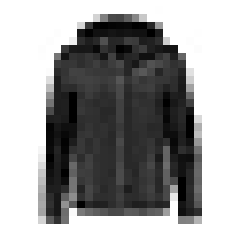

In [ ]:
plt.imshow(X_train[0], cmap="binary")
plt.axis('off')
plt.show()

The labels are the class IDs (represented as uint8), from 0 to 9:

In [ ]:
y_train

array([4, 0, 7, ..., 3, 0, 5], dtype=uint8)

Here are the corresponding class names:

In [ ]:
class_names = ["T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
               "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"]

So the first image in the training set is a coat:

In [ ]:
class_names[y_train[0]]

'Coat'

The validation set contains 5,000 images, and the test set contains 10,000 images:

In [ ]:
X_valid.shape

(5000, 28, 28)

In [ ]:
X_test.shape

(10000, 28, 28)

Let's take a look at a sample of the images in the dataset:

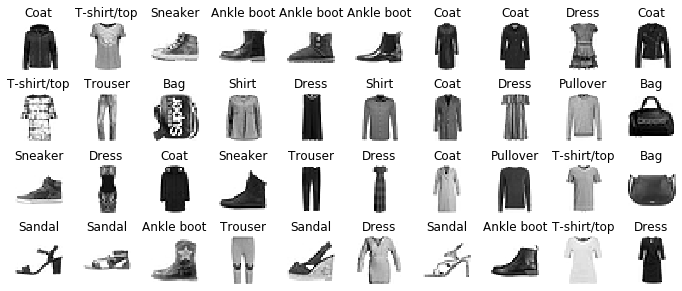

In [ ]:
n_rows = 4
n_cols = 10
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X_train[index], cmap="binary", interpolation="nearest")
        plt.axis('off')
        plt.title(class_names[y_train[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

### Creating the model using the Sequential API
Now let’s build the neural network! Here is a classification MLP with two hidden layers:



In [ ]:
model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape=[28, 28]))
model.add(keras.layers.Dense(300, activation="relu"))
model.add(keras.layers.Dense(100, activation="relu"))
model.add(keras.layers.Dense(50, activation="relu"))
model.add(keras.layers.Dense(20, activation="relu"))
model.add(keras.layers.Dense(10, activation="softmax"))

Let’s go through this code line by line:
- The first line creates a Sequential model. This is the simplest kind of Keras model for neural networks that are just composed of a single stack of layers connected sequentially. This is called the Sequential API.
- Next, we build the first layer and add it to the model. It is a Flatten layer whose role is to convert each input image into a 1D array: if it receives input data X, it computes X.reshape(-1, 1). This layer does not have any parameters; it is just there to do some simple preprocessing. Since it is the first layer in the model, you should specify the input_shape, which doesn’t include the batch size, only the shape of the instances. Alternatively, you could add a keras.layers.InputLayer as the first layer, setting input_shape=[28,28].
- Next we add a Dense hidden layer with 300 neurons. It will use the ReLU activation function. Each Dense layer manages its own weight matrix, containing all the connection weights between the neurons and their inputs. It also manages a vector of bias terms (one per neuron). When it receives some input data.
- Then we add a second Dense hidden layer with 100 neurons, also using the ReLU activation function.
- Finally, we add a Dense output layer with 10 neurons (one per class), using the softmax activation function (because the classes are exclusive).

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

Instead of adding the layers one by one as we just did, you can pass a list of layers
when creating the Sequential model:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[28, 28]),
    keras.layers.Dense(300, activation="relu"),
    keras.layers.Dense(100, activation="relu"),
    keras.layers.Dense(10, activation="softmax")
])

In [ ]:
model.layers

The model’s summary() method displays all the model’s layers,including each layer’s
name (which is automatically generated unless you set it when creating the layer), its
output shape (None means the batch size can be anything), and its number of parameters.
The summary ends with the total number of parameters, including trainable and
non-trainable parameters. Here we only have trainable parameters

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 300)               235500    
_________________________________________________________________
dense_1 (Dense)              (None, 100)               30100     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                1010      
Total params: 266,610
Trainable params: 266,610
Non-trainable params: 0
_________________________________________________________________


In [ ]:
784*300+300, 300*100+100, 100*10+10

(235500, 30100, 1010)

Note that Dense layers often have a lot of parameters. For example, the first hidden
layer has 784 × 300 connection weights, plus 300 bias terms, which adds up to
235,500 parameters! This gives the model quite a lot of flexibility to fit the training
data, but it also means that the model runs the risk of overfitting, especially when you
do not have a lot of training data.

In [ ]:
keras.utils.plot_model(model, "my_mnist_model.png", show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


You can easily get a model’s list of layers, to fetch a layer by its index, or you can fetch
it by name:

In [ ]:
hidden1 = model.layers[1]
hidden1.name

'dense'

In [ ]:
model.get_layer(hidden1.name) is hidden1

True

All the parameters of a layer can be accessed using its get_weights() and
set_weights() methods. For a Dense layer, this includes both the connection weights
and the bias terms:

In [ ]:
weights, biases = hidden1.get_weights()

In [ ]:
weights

array([[ 0.02448617, -0.00877795, -0.02189048, ..., -0.02766046,
         0.03859074, -0.06889391],
       [ 0.00476504, -0.03105379, -0.0586676 , ...,  0.00602964,
        -0.02763776, -0.04165364],
       [-0.06189284, -0.06901957,  0.07102345, ..., -0.04238207,
         0.07121518, -0.07331658],
       ...,
       [-0.03048757,  0.02155137, -0.05400612, ..., -0.00113463,
         0.00228987,  0.05581069],
       [ 0.07061854, -0.06960931,  0.07038955, ..., -0.00384101,
         0.00034875,  0.02878492],
       [-0.06022581,  0.01577859, -0.02585464, ..., -0.00527829,
         0.00272203, -0.06793761]], dtype=float32)

In [ ]:
weights.shape

(784, 300)

In [ ]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [ ]:
biases.shape

(300,)

Notice that the Dense layer initialized the connection weights randomly (which is
needed to break symmetry, as we discussed earlier), and the biases were initialized to
zeros, which is fine. If you ever want to use a different initialization method, you can
set kernel_initializer (kernel is another name for the matrix of connection weights) or bias_initializer when creating the layer.

### Compiling the model
After a model is created, you must call its compile() method to specify the loss function
and the optimizer to use. Optionally, you can specify a list of extra metrics to
compute during training and evaluation:

In [ ]:
model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam",
              metrics=["accuracy"])

First, we use the "sparse_categorical_cross
entropy" loss because we have sparse labels (i.e., for each instance, there is just a target
class index, from 0 to 9 in this case), and the classes are exclusive. If instead we
had one target probability per class for each instance (such as one-hot vectors, e.g.
[0., 0., 0., 1., 0., 0., 0., 0., 0., 0.] to represent class 3), then we would
need to use the "categorical_crossentropy" loss instead. If we were doing binary
classification (with one or more binary labels), then we would use the "sigmoid" (i.e.,
logistic) activation function in the output layer instead of the "softmax" activation
function, and we would use the "binary_crossentropy" loss.

Regarding the optimizer, "sgd" means that we will train the model using simple Stochastic
Gradient Descent. In other words, Keras will perform the backpropagation
algorithm described earlier (i.e., reverse-mode autodiff plus Gradient Descent).

Finally, since this is a classifier, it’s useful to measure its "accuracy" during training
and evaluation.

This is equivalent to:

```python
model.compile(loss=keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.SGD(),
              metrics=[keras.metrics.sparse_categorical_accuracy])
```

### Training and evaluating the model
Now the model is ready to be trained. For this we simply need to call its fit() method:

In [ ]:
history = model.fit(X_train, y_train, epochs=30,
                    validation_data=(X_valid, y_valid))

Train on 55000 samples, validate on 5000 samples
Epoch 1/30
55000/55000 [==============================] - 7s 126us/sample - loss: 0.7226 - accuracy: 0.7641 - val_loss: 0.5073 - val_accuracy: 0.8320
Epoch 2/30
55000/55000 [==============================] - 5s 93us/sample - loss: 0.4844 - accuracy: 0.8321 - val_loss: 0.4540 - val_accuracy: 0.8488
Epoch 3/30
55000/55000 [==============================] - 5s 91us/sample - loss: 0.4414 - accuracy: 0.8465 - val_loss: 0.4378 - val_accuracy: 0.8498
Epoch 4/30
55000/55000 [==============================] - 5s 94us/sample - loss: 0.4129 - accuracy: 0.8547 - val_loss: 0.4158 - val_accuracy: 0.8558
Epoch 5/30
55000/55000 [==============================] - 5s 96us/sample - loss: 0.3927 - accuracy: 0.8617 - val_loss: 0.3810 - val_accuracy: 0.8646
Epoch 6/30
55000/55000 [==============================] - 5s 97us/sample - loss: 0.3770 - accuracy: 0.8666 - val_loss: 0.3729 - val_accuracy: 0.8686
Epoch 7/30
55000/55000 [==============================] 

We pass it the input features (X_train) and the target classes (y_train), as well as the
number of epochs to train (or else it would default to just 1, which would definitely
not be enough to converge to a good solution). We also pass a validation set (this is
optional). Keras will measure the loss and the extra metrics on this set at the end of
each epoch, which is very useful to see how well the model really performs. If the performance
on the training set is much better than on the validation set, your model is probably overfitting the training set (or there is a bug, such as a data mismatch
between the training set and the validation set).

At each epoch during training, Keras
displays the number of instances processed so far (along with a progress bar), the
mean training time per sample, and the loss and accuracy (or any other extra metrics
you asked for) on both the training set and the validation set. You can see that the
training loss went down, which is a good sign, and the validation accuracy reached
89.26% after 30 epochs.

In [ ]:
history.params

{'batch_size': 32,
 'epochs': 30,
 'steps': 1719,
 'samples': 55000,
 'verbose': 0,
 'do_validation': True,
 'metrics': ['loss', 'accuracy', 'val_loss', 'val_accuracy']}

In [ ]:
print(history.epoch)

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]


In [ ]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

The fit() method returns a History object containing the training parameters
(history.params), the list of epochs it went through (history.epoch), and most
importantly a dictionary (history.history) containing the loss and extra metrics it
measured at the end of each epoch on the training set and on the validation set (if
any). If you use this dictionary to create a pandas DataFrame and call its plot()
method, you get the learning curves:

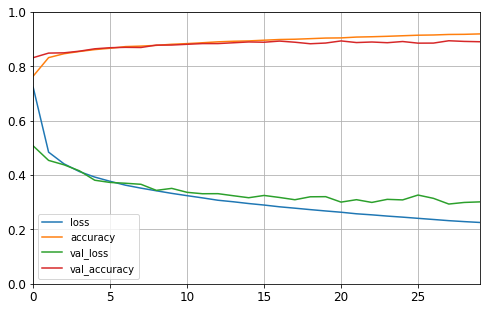

In [ ]:
import pandas as pd

pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1)

plt.show()

You can see that both the training accuracy and the validation accuracy steadily
increase during training, while the training loss and the validation loss decrease.
Good! Moreover, the validation curves are close to the training curves, which means
that there is not too much overfitting. In this particular case, the model looks like it
performed better on the validation set than on the training set at the beginning of
training. But that’s not the case: indeed, the validation error is computed at the end of
each epoch, while the training error is computed using a running mean during each
epoch. So the training curve should be shifted by half an epoch to the left. If you do
that, you will see that the training and validation curves overlap almost perfectly at
the beginning of training.

The training set performance ends up beating the validation performance, as is generally
the case when you train for long enough. You can tell that the model has not
quite converged yet, as the validation loss is still going down, so you should probably
continue training. It’s as simple as calling the fit() method again, since Keras just
continues training where it left off (you should be able to reach close to 89% validation
accuracy).

If you are not satisfied with the performance of your model, you should go back and
tune the hyperparameters. The first one to check is the learning rate. If that doesn’t
help, try another optimizer (and always retune the learning rate after changing any
hyperparameter). If the performance is still not great, then try tuning model hyperparameters
such as the number of layers, the number of neurons per layer, and the
types of activation functions to use for each hidden layer. You can also try tuning
other hyperparameters, such as the batch size (it can be set in the fit() method using
the batch_size argument, which defaults to 32). We will get back to hyperparameter
tuning at the end of this chapter. Once you are satisfied with your model’s validation
accuracy, you should evaluate it on the test set to estimate the generalization error
before you deploy the model to production. You can easily do this using the evalu
ate() method (it also supports several other arguments, such as batch_size and
sample_weight):

In [ ]:
model.evaluate(X_test, y_test)

10000/10000 [==============================] - 1s 92us/sample - loss: 0.3340 - accuracy: 0.8804


[0.333983403301239, 0.8804]

### Using the model to make predictions
Next, we can use the model’s predict() method to make predictions on new instances.
Since we don’t have actual new instances, we will just use the first three instances
of the test set:

In [ ]:
X_new = X_test[:3]
y_proba = model.predict(X_new)
y_proba.round(2)

array([[0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.01, 0.  , 0.98],
       [0.  , 0.  , 0.99, 0.  , 0.01, 0.  , 0.  , 0.  , 0.  , 0.  ],
       [0.  , 1.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ]],
      dtype=float32)

As you can see, for each instance the model estimates one probability per class, from
class 0 to class 9. For example, for the first image it estimates that the probability of
class 9 (ankle boot) is 96%, the probability of class 5 (sandal) is 3%, the probability of
class 7 (sneaker) is 1%, and the probabilities of the other classes are negligible. In
other words, it “believes” the first image is footwear, most likely ankle boots but possibly
sandals or sneakers. If you only care about the class with the highest estimated
probability (even if that probability is quite low), then you can use the pre
dict_classes() method instead:

In [ ]:
y_pred = model.predict_classes(X_new)
y_pred

array([9, 2, 1])

In [ ]:
np.array(class_names)[y_pred]

array(['Ankle boot', 'Pullover', 'Trouser'], dtype='<U11')

In [ ]:
y_new = y_test[:3]
y_new

array([9, 2, 1], dtype=uint8)

Here, the classifier actually classified all three images correctly

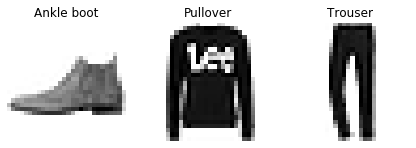

In [ ]:
plt.figure(figsize=(7.2, 2.4))
for index, image in enumerate(X_new):
    plt.subplot(1, 3, index + 1)
    plt.imshow(image, cmap="binary", interpolation="nearest")
    plt.axis('off')
    plt.title(class_names[y_test[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)

plt.show()

## Building a Regression MLP Using the Sequential API

Let's load, split and scale the California housing dataset

In [ ]:
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

housing = fetch_california_housing()

X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full, random_state=42)

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

Using the Sequential API to build, train, evaluate, and use a regression MLP to make
predictions is quite similar to what we did for classification. The main differences are
the fact that the output layer has a single neuron (since we only want to predict a single
value) and uses no activation function, and the loss function is the mean squared
error. Since the dataset is quite noisy, we just use a single hidden layer with fewer
neurons than before, to avoid overfitting:

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])
model.compile(loss="mean_squared_error", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)
X_new = X_test[:3]
y_pred = model.predict(X_new)

Train on 11610 samples, validate on 3870 samples
Epoch 1/20
11610/11610 [==============================] - 1s 87us/sample - loss: 1.6205 - val_loss: 2.0374
Epoch 2/20
11610/11610 [==============================] - 1s 63us/sample - loss: 0.7162 - val_loss: 0.6571
Epoch 3/20
11610/11610 [==============================] - 1s 64us/sample - loss: 0.6356 - val_loss: 0.5996
Epoch 4/20
11610/11610 [==============================] - 1s 67us/sample - loss: 0.5989 - val_loss: 0.5662
Epoch 5/20
11610/11610 [==============================] - 1s 87us/sample - loss: 0.5713 - val_loss: 0.5489
Epoch 6/20
11610/11610 [==============================] - 1s 104us/sample - loss: 0.5491 - val_loss: 0.5204
Epoch 7/20
11610/11610 [==============================] - 1s 83us/sample - loss: 0.5301 - val_loss: 0.5018
Epoch 8/20
11610/11610 [==============================] - 1s 74us/sample - loss: 0.5142 - val_loss: 0.4815
Epoch 9/20
11610/11610 [==============================] - 1s 77us/sample - loss: 0.5004 - val_

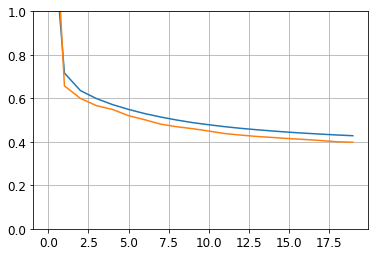

In [ ]:
plt.plot(pd.DataFrame(history.history))
plt.grid(True)
plt.gca().set_ylim(0, 1)
plt.show()

In [ ]:
y_pred

array([[0.37310064],
       [1.6790789 ],
       [3.0817137 ]], dtype=float32)

## Saving and Restoring a Model
When using the Sequential API or the Functional API, saving a trained Keras model is as simple as it gets:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
history = model.fit(X_train, y_train, epochs=10, validation_data=(X_valid, y_valid))
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 2s 136us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/10
11610/11610 [==============================] - 1s 70us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/10
11610/11610 [==============================] - 1s 71us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/10
11610/11610 [==============================] - 1s 70us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/10
11610/11610 [==============================] - 1s 69us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/10
11610/11610 [==============================] - 1s 75us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/10
11610/11610 [==============================] - 1s 78us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/10
11610/11610 [==============================] - 1s 88us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/10
11610/11610 [==============================] - 1s 105us/sample - loss: 0.4576 - val

Keras will use the HDF5 format to save both the model’s architecture (including every
layer’s hyperparameters) and the values of all the model parameters for every layer
(e.g., connection weights and biases). It also saves the optimizer (including its hyperparameters
and any state it may have).

In [ ]:
model.save("my_keras_model.h5")

You will typically have a script that trains a model and saves it, and one or more
scripts (or web services) that load the model and use it to make predictions. Loading
the model is just as easy:

In [ ]:
model = keras.models.load_model("my_keras_model.h5")

In [ ]:
model.predict(X_new)

array([[0.551559 ],
       [1.6555369],
       [3.0014234]], dtype=float32)

In [ ]:
model.save_weights("my_keras_weights.ckpt")

In [ ]:
model.load_weights("my_keras_weights.ckpt")

# Using Callbacks during Training

But what if training lasts several hours? This is quite common, especially when training
on large datasets. In this case, you should not only save your model at the end of
training, but also save checkpoints at regular intervals during training, to avoid losing
everything if your computer crashes. But how can you tell the fit() method to save
checkpoints? Use callbacks.

The fit() method accepts a callbacks argument that lets you specify a list of objects
that Keras will call at the start and end of training, at the start and end of each epoch,
and even before and after processing each batch. For example, the ModelCheckpoint
callback saves checkpoints of your model at regular intervals during training, by
default at the end of each epoch:

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation="relu", input_shape=[8]),
    keras.layers.Dense(30, activation="relu"),
    keras.layers.Dense(1)
])

Moreover, if you use a validation set during training, you can set
save_best_only=True when creating the ModelCheckpoint. In this case, it will only
save your model when its performance on the validation set is the best so far. This
way, you do not need to worry about training for too long and overfitting the training
set: simply restore the last model saved after training, and this will be the best model
on the validation set. The following code is a simple way to implement early stopping

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
checkpoint_cb = keras.callbacks.ModelCheckpoint("my_keras_model.h5", save_best_only=True)
history = model.fit(X_train, y_train, epochs=10,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb])
model = keras.models.load_model("my_keras_model.h5") # rollback to best model
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/10
11610/11610 [==============================] - 2s 194us/sample - loss: 1.8423 - val_loss: 5.2165
Epoch 2/10
11610/11610 [==============================] - 1s 113us/sample - loss: 0.6876 - val_loss: 0.7732
Epoch 3/10
11610/11610 [==============================] - 1s 113us/sample - loss: 0.5954 - val_loss: 0.5446
Epoch 4/10
11610/11610 [==============================] - 2s 137us/sample - loss: 0.5553 - val_loss: 0.5425
Epoch 5/10
11610/11610 [==============================] - 2s 132us/sample - loss: 0.5268 - val_loss: 0.5539
Epoch 6/10
11610/11610 [==============================] - 1s 66us/sample - loss: 0.5049 - val_loss: 0.4701
Epoch 7/10
11610/11610 [==============================] - 1s 85us/sample - loss: 0.4852 - val_loss: 0.4562
Epoch 8/10
11610/11610 [==============================] - 1s 87us/sample - loss: 0.4706 - val_loss: 0.4452
Epoch 9/10
11610/11610 [==============================] - 1s 100us/sample - loss: 0.4576 -

Another way to implement early stopping is to simply use the EarlyStopping callback.
It will interrupt training when it measures no progress on the validation set for a number of epochs (defined by the patience argument), and it will optionally roll
back to the best model. You can combine both callbacks to save checkpoints of your
model (in case your computer crashes) and interrupt training early when there is no
more progress (to avoid wasting time and resources):

In [ ]:
model.compile(loss="mse", optimizer=keras.optimizers.SGD(lr=1e-3))
early_stopping_cb = keras.callbacks.EarlyStopping(patience=5,
                                                  restore_best_weights=True)
history = model.fit(X_train, y_train, epochs=100,
                    validation_data=(X_valid, y_valid),
                    callbacks=[checkpoint_cb, early_stopping_cb])
mse_test = model.evaluate(X_test, y_test)

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 2s 139us/sample - loss: 0.4385 - val_loss: 0.4287
Epoch 2/100
11610/11610 [==============================] - 1s 112us/sample - loss: 0.4319 - val_loss: 0.4117
Epoch 3/100
11610/11610 [==============================] - 1s 120us/sample - loss: 0.4252 - val_loss: 0.3975
Epoch 4/100
11610/11610 [==============================] - 1s 64us/sample - loss: 0.4199 - val_loss: 0.3943
Epoch 5/100
11610/11610 [==============================] - 1s 74us/sample - loss: 0.4150 - val_loss: 0.3964
Epoch 6/100
11610/11610 [==============================] - 1s 58us/sample - loss: 0.4110 - val_loss: 0.3907
Epoch 7/100
11610/11610 [==============================] - 1s 61us/sample - loss: 0.4070 - val_loss: 0.3823
Epoch 8/100
11610/11610 [==============================] - 1s 61us/sample - loss: 0.4036 - val_loss: 0.3786
Epoch 9/100
11610/11610 [==============================] - 1s 54us/sample - loss: 0.

11610/11610 [==============================] - 1s 60us/sample - loss: 0.3345 - val_loss: 0.3476
Epoch 76/100
11610/11610 [==============================] - 1s 88us/sample - loss: 0.3341 - val_loss: 0.3196
Epoch 77/100
11610/11610 [==============================] - 2s 135us/sample - loss: 0.3338 - val_loss: 0.3608
Epoch 78/100
11610/11610 [==============================] - 1s 91us/sample - loss: 0.3336 - val_loss: 0.3295
Epoch 79/100
11610/11610 [==============================] - 2s 142us/sample - loss: 0.3331 - val_loss: 0.3927
Epoch 80/100
11610/11610 [==============================] - 1s 92us/sample - loss: 0.3332 - val_loss: 0.3167
Epoch 81/100
11610/11610 [==============================] - 1s 123us/sample - loss: 0.3317 - val_loss: 0.3783
Epoch 82/100
11610/11610 [==============================] - 1s 66us/sample - loss: 0.3322 - val_loss: 0.3154
Epoch 83/100
11610/11610 [==============================] - 1s 93us/sample - loss: 0.3315 - val_loss: 0.3538
Epoch 84/100
11610/11610 [===

The number of epochs can be set to a large value since training will stop automatically
when there is no more progress. In this case, there is no need to restore the best
model saved because the EarlyStopping callback will keep track of the best weights
and restore them for you at the end of training.

If you need extra control, you can easily write your own custom callbacks. As an
example of how to do that, the following custom callback will display the ratio
between the validation loss and the training loss during training (e.g., to detect overfitting):

In [ ]:
class PrintValTrainRatioCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        print("\nval/train: {:.2f}".format(logs["val_loss"] / logs["loss"]))

In [ ]:
val_train_ratio_cb = PrintValTrainRatioCallback()
history = model.fit(X_train, y_train, epochs=1,
                    validation_data=(X_valid, y_valid),
                    callbacks=[val_train_ratio_cb])

Train on 11610 samples, validate on 3870 samples
10912/11610 [===========================>..] - ETA: 0s - loss: 0.3231
val/train: 1.16
11610/11610 [==============================] - 1s 66us/sample - loss: 0.3256 - val_loss: 0.3785


As you might expect, you can implement on_train_begin(), on_train_end(),
on_epoch_begin(), on_epoch_end(), on_batch_begin(), and on_batch_end(). Callbacks
can also be used during evaluation and predictions, should you ever need them
(e.g., for debugging). For evaluation, you should implement on_test_begin(),
on_test_end(), on_test_batch_begin(), or on_test_batch_end() (called by evalu
ate()), and for prediction you should implement on_predict_begin(), on_pre
dict_end(), on_predict_batch_begin(), or on_predict_batch_end() (called by
predict()).

# Hyperparameter Tuning

The flexibility of neural networks is also one of their main drawbacks: there are many
hyperparameters to tweak. Not only can you use any imaginable network architecture,
but even in a simple MLP you can change the number of layers, the number of
neurons per layer, the type of activation function to use in each layer, the weight initialization
logic, and much more

In [ ]:
keras.backend.clear_session()
np.random.seed(42)
tf.random.set_seed(42)

One option is to simply try many combinations of hyperparameters and see which
one works best on the validation set (or use K-fold cross-validation). For example, we
can use GridSearchCV or RandomizedSearchCV. To do this, we need to wrap our Keras models in objects that
mimic regular Scikit-Learn regressors. The first step is to create a function that will
build and compile a Keras model, given a set of hyperparameters:

In [ ]:
def build_model(n_hidden=1, n_neurons=30, learning_rate=3e-3, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.InputLayer(input_shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation="relu"))
    model.add(keras.layers.Dense(1))
    optimizer = keras.optimizers.SGD(lr=learning_rate)
    model.compile(loss="mse", optimizer=optimizer)
    return model

This function creates a simple Sequential model for univariate regression (only one
output neuron), with the given input shape and the given number of hidden layers
and neurons, and it compiles it using an SGD optimizer configured with the specified
learning rate. It is good practice to provide reasonable defaults to as many hyperparameters
as you can, as Scikit-Learn does.

Next, let’s create a KerasRegressor based on this build_model() function:

In [ ]:
keras_reg = keras.wrappers.scikit_learn.KerasRegressor(build_model)

The KerasRegressor object is a thin wrapper around the Keras model built using
build_model(). Since we did not specify any hyperparameters when creating it, it
will use the default hyperparameters we defined in build_model(). Now we can use
this object like a regular Scikit-Learn regressor: we can train it using its fit()
method, then evaluate it using its score() method, and use it to make predictions
using its predict() method, as you can see in the following code:

In [ ]:
keras_reg.fit(X_train, y_train, epochs=100,
              validation_data=(X_valid, y_valid),
              callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Train on 11610 samples, validate on 3870 samples
Epoch 1/100
11610/11610 [==============================] - 1s 87us/sample - loss: 1.1399 - val_loss: 24.4309
Epoch 2/100
11610/11610 [==============================] - 1s 84us/sample - loss: 0.7393 - val_loss: 3.2896
Epoch 3/100
11610/11610 [==============================] - 1s 66us/sample - loss: 0.5374 - val_loss: 0.6080
Epoch 4/100
11610/11610 [==============================] - 1s 73us/sample - loss: 0.4796 - val_loss: 0.4532
Epoch 5/100
11610/11610 [==============================] - 1s 62us/sample - loss: 0.4536 - val_loss: 0.4221
Epoch 6/100
11610/11610 [==============================] - 1s 62us/sample - loss: 0.4373 - val_loss: 0.4144
Epoch 7/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.4256 - val_loss: 0.4025
Epoch 8/100
11610/11610 [==============================] - 1s 80us/sample - loss: 0.4178 - val_loss: 0.3938
Epoch 9/100
11610/11610 [==============================] - 1s 65us/sample - loss: 0.41

In [ ]:
mse_test = keras_reg.score(X_test, y_test)

5160/5160 [==============================] - 0s 59us/sample - loss: 0.3464


In [ ]:
y_pred = keras_reg.predict(X_new)

Note that any extra parameter you pass to the fit() method will get passed to the
underlying Keras model. Also note that the score will be the opposite of the MSE
because Scikit-Learn wants scores, not losses (i.e., higher should be better).

We don’t want to train and evaluate a single model like this, though we want to train
hundreds of variants and see which one performs best on the validation set. Since
there are many hyperparameters, it is preferable to use a randomized search rather
than grid search. Let’s try to explore the number of
hidden layers, the number of neurons, and the learning rate:

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

In [ ]:
from scipy.stats import reciprocal
from sklearn.model_selection import RandomizedSearchCV

param_distribs = {
    "n_hidden": [0, 1, 2, 3],
    "n_neurons": np.arange(1, 100),
    "learning_rate": reciprocal(3e-4, 3e-2),
}

rnd_search_cv = RandomizedSearchCV(keras_reg, param_distribs, n_iter=10, cv=3, verbose=2)
rnd_search_cv.fit(X_train, y_train, epochs=100,
                  validation_data=(X_valid, y_valid),
                  callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] learning_rate=0.001683454924600351, n_hidden=0, n_neurons=15 ....


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 154us/sample - loss: 3.5574 - val_loss: 1.8536
Epoch 2/100
7740/7740 [==============================] - 0s 56us/sample - loss: 1.3316 - val_loss: 0.9380
Epoch 3/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.8573 - val_loss: 0.8545
Epoch 4/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.7344 - val_loss: 0.9545
Epoch 5/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.6943 - val_loss: 0.7248
Epoch 6/100
7740/7740 [==============================] - 0s 55us/sample - loss: 0.6682 - val_loss: 0.7356
Epoch 7/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.6494 - val_loss: 0.9732
Epoch 8/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.6408 - val_loss: 0.6175
Epoch 9/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.6256 - val_loss: 0.58

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.5s remaining:    0.0s


7740/7740 [==============================] - 1s 93us/sample - loss: 3.5541 - val_loss: 23.2063
Epoch 2/100
7740/7740 [==============================] - 0s 61us/sample - loss: 1.4756 - val_loss: 10.9096
Epoch 3/100
7740/7740 [==============================] - 0s 64us/sample - loss: 1.0159 - val_loss: 4.5194
Epoch 4/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.8738 - val_loss: 1.5793
Epoch 5/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.8034 - val_loss: 0.7218
Epoch 6/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.7549 - val_loss: 1.1511
Epoch 7/100
7740/7740 [==============================] - 1s 68us/sample - loss: 0.7166 - val_loss: 2.3325
Epoch 8/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.6854 - val_loss: 3.9493
Epoch 9/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.6593 - val_loss: 5.7393
Epoch 10/100
7740/7740 [==============================] 

7740/7740 [==============================] - 1s 82us/sample - loss: 0.5027 - val_loss: 20.9402
Epoch 17/100
7740/7740 [==============================] - 0s 57us/sample - loss: 0.5022 - val_loss: 20.5891
Epoch 18/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.5031 - val_loss: 20.7123
Epoch 19/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.5014 - val_loss: 17.3551
Epoch 20/100
7740/7740 [==============================] - 1s 73us/sample - loss: 0.5013 - val_loss: 20.4442
Epoch 21/100
3870/3870 [==============================] - 0s 43us/sample - loss: 1.0074
[CV]  learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21, total=  12.0s
[CV] learning_rate=0.008731907739399206, n_hidden=0, n_neurons=21 ....
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 102us/sample - loss: 1.4056 - val_loss: 28.7777
Epoch 2/100
7740/7740 [==============================] - 0s 62us/sample - lo

Epoch 55/100
7740/7740 [==============================] - 1s 133us/sample - loss: 0.3700 - val_loss: 0.3698
Epoch 56/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.3691 - val_loss: 0.3854
Epoch 57/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.3682 - val_loss: 0.3874
Epoch 58/100
7740/7740 [==============================] - 1s 97us/sample - loss: 0.3670 - val_loss: 0.3942
Epoch 59/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.3663 - val_loss: 0.3821
Epoch 60/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.3654 - val_loss: 0.3882
Epoch 61/100
7740/7740 [==============================] - 1s 71us/sample - loss: 0.3644 - val_loss: 0.3779
Epoch 62/100
7740/7740 [==============================] - 1s 68us/sample - loss: 0.3634 - val_loss: 0.3693
Epoch 63/100
7740/7740 [==============================] - 1s 81us/sample - loss: 0.3628 - val_loss: 0.3734
Epoch 64/100
7740/7740 [============

Epoch 29/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.4152 - val_loss: 0.4260
Epoch 30/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.4125 - val_loss: 0.4350
Epoch 31/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.4099 - val_loss: 0.4413
Epoch 32/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.4076 - val_loss: 0.4439
Epoch 33/100
7740/7740 [==============================] - 1s 89us/sample - loss: 0.4052 - val_loss: 0.4513
Epoch 34/100
7740/7740 [==============================] - 1s 79us/sample - loss: 0.4029 - val_loss: 0.4671
Epoch 35/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.4010 - val_loss: 0.4686
Epoch 36/100
7740/7740 [==============================] - 1s 74us/sample - loss: 0.3988 - val_loss: 0.4745
Epoch 37/100
3870/3870 [==============================] - 0s 36us/sample - loss: 0.4098
[CV]  learning_rate=0.0006154014789262348, n_hidden=2, n

7740/7740 [==============================] - 1s 81us/sample - loss: 0.8942 - val_loss: 4.2789
Epoch 4/100
7740/7740 [==============================] - 1s 76us/sample - loss: 0.8105 - val_loss: 3.3544
Epoch 5/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.7686 - val_loss: 2.6742
Epoch 6/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.7406 - val_loss: 2.2971
Epoch 7/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.7187 - val_loss: 2.0216
Epoch 8/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.7000 - val_loss: 1.7849
Epoch 9/100
7740/7740 [==============================] - 1s 80us/sample - loss: 0.6825 - val_loss: 1.5810
Epoch 10/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.6676 - val_loss: 1.4502
Epoch 11/100
7740/7740 [==============================] - 1s 85us/sample - loss: 0.6530 - val_loss: 1.3239
Epoch 12/100
7740/7740 [==============================] 

7740/7740 [==============================] - 1s 80us/sample - loss: 1.1658 - val_loss: 20.2997
Epoch 6/100
7740/7740 [==============================] - 1s 73us/sample - loss: 1.0236 - val_loss: 14.4998
Epoch 7/100
7740/7740 [==============================] - 1s 92us/sample - loss: 0.9247 - val_loss: 10.3206
Epoch 8/100
7740/7740 [==============================] - 1s 79us/sample - loss: 0.8582 - val_loss: 7.2174
Epoch 9/100
7740/7740 [==============================] - 1s 106us/sample - loss: 0.8127 - val_loss: 5.0609
Epoch 10/100
7740/7740 [==============================] - 1s 76us/sample - loss: 0.7805 - val_loss: 3.8504
Epoch 11/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.7553 - val_loss: 2.6823
Epoch 12/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.7345 - val_loss: 1.9608
Epoch 13/100
7740/7740 [==============================] - 1s 78us/sample - loss: 0.7165 - val_loss: 1.5395
Epoch 14/100
7740/7740 [==========================

7740/7740 [==============================] - 1s 81us/sample - loss: 0.4334 - val_loss: 0.4516
Epoch 50/100
7740/7740 [==============================] - 1s 79us/sample - loss: 0.4319 - val_loss: 0.4455
Epoch 51/100
7740/7740 [==============================] - 1s 75us/sample - loss: 0.4304 - val_loss: 0.4405
Epoch 52/100
7740/7740 [==============================] - 1s 74us/sample - loss: 0.4292 - val_loss: 0.4437
Epoch 53/100
7740/7740 [==============================] - 1s 80us/sample - loss: 0.4277 - val_loss: 0.4417
Epoch 54/100
7740/7740 [==============================] - 1s 183us/sample - loss: 0.4266 - val_loss: 0.4433
Epoch 55/100
7740/7740 [==============================] - 1s 88us/sample - loss: 0.4252 - val_loss: 0.4468
Epoch 56/100
7740/7740 [==============================] - 1s 136us/sample - loss: 0.4241 - val_loss: 0.4536
Epoch 57/100
7740/7740 [==============================] - 1s 104us/sample - loss: 0.4228 - val_loss: 0.4470
Epoch 58/100
7740/7740 [=======================

7740/7740 [==============================] - 2s 212us/sample - loss: 0.3438 - val_loss: 0.3788
Epoch 20/100
7740/7740 [==============================] - 1s 149us/sample - loss: 0.3429 - val_loss: 0.3633
Epoch 21/100
7740/7740 [==============================] - 1s 78us/sample - loss: 0.3408 - val_loss: 0.3366
Epoch 22/100
7740/7740 [==============================] - 1s 117us/sample - loss: 0.3400 - val_loss: 0.3583
Epoch 23/100
7740/7740 [==============================] - 1s 153us/sample - loss: 0.3397 - val_loss: 0.3759
Epoch 24/100
7740/7740 [==============================] - 1s 102us/sample - loss: 0.3373 - val_loss: 0.3592
Epoch 25/100
7740/7740 [==============================] - 1s 100us/sample - loss: 0.3364 - val_loss: 0.3754
Epoch 26/100
7740/7740 [==============================] - 1s 84us/sample - loss: 0.3354 - val_loss: 0.3558
Epoch 27/100
7740/7740 [==============================] - 1s 98us/sample - loss: 0.3343 - val_loss: 0.3720
Epoch 28/100
7740/7740 [====================

7740/7740 [==============================] - 0s 54us/sample - loss: 0.3433 - val_loss: 0.3447
Epoch 46/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.3438 - val_loss: 0.3555
Epoch 47/100
7740/7740 [==============================] - 1s 87us/sample - loss: 0.3457 - val_loss: 0.3562
Epoch 48/100
7740/7740 [==============================] - 1s 78us/sample - loss: 0.3399 - val_loss: 0.3606
Epoch 49/100
7740/7740 [==============================] - 1s 104us/sample - loss: 0.3391 - val_loss: 0.3702
Epoch 50/100
3870/3870 [==============================] - 0s 33us/sample - loss: 0.3416
[CV]  learning_rate=0.008339092654580042, n_hidden=1, n_neurons=38, total=  31.7s
[CV] learning_rate=0.00030107783636342726, n_hidden=3, n_neurons=21 ..
Train on 7740 samples, validate on 3870 samples
Epoch 1/100
7740/7740 [==============================] - 1s 117us/sample - loss: 4.0249 - val_loss: 8.1049
Epoch 2/100
7740/7740 [==============================] - 1s 71us/sample - loss: 2

Epoch 69/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.4302 - val_loss: 0.4192
Epoch 70/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.4282 - val_loss: 0.4172
Epoch 71/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.4260 - val_loss: 0.4151
Epoch 72/100
7740/7740 [==============================] - 1s 73us/sample - loss: 0.4243 - val_loss: 0.4132
Epoch 73/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.4224 - val_loss: 0.4112
Epoch 74/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.4204 - val_loss: 0.4092
Epoch 75/100
7740/7740 [==============================] - 1s 67us/sample - loss: 0.4188 - val_loss: 0.4074
Epoch 76/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.4170 - val_loss: 0.4056
Epoch 77/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.4152 - val_loss: 0.4039
Epoch 78/100
7740/7740 [=============

7740/7740 [==============================] - 1s 86us/sample - loss: 0.6236 - val_loss: 0.5963
Epoch 15/100
7740/7740 [==============================] - 1s 82us/sample - loss: 0.6152 - val_loss: 0.5853
Epoch 16/100
7740/7740 [==============================] - 1s 142us/sample - loss: 0.6072 - val_loss: 0.5758
Epoch 17/100
7740/7740 [==============================] - 1s 109us/sample - loss: 0.5993 - val_loss: 0.5672
Epoch 18/100
7740/7740 [==============================] - 2s 255us/sample - loss: 0.5916 - val_loss: 0.5599
Epoch 19/100
7740/7740 [==============================] - 1s 81us/sample - loss: 0.5842 - val_loss: 0.5519
Epoch 20/100
7740/7740 [==============================] - 1s 139us/sample - loss: 0.5769 - val_loss: 0.5446
Epoch 21/100
7740/7740 [==============================] - 1s 105us/sample - loss: 0.5698 - val_loss: 0.5376
Epoch 22/100
7740/7740 [==============================] - 0s 61us/sample - loss: 0.5628 - val_loss: 0.5309
Epoch 23/100
7740/7740 [=====================

7740/7740 [==============================] - 1s 67us/sample - loss: 0.3998 - val_loss: 0.4262
Epoch 13/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.3988 - val_loss: 0.4753
Epoch 14/100
7740/7740 [==============================] - 0s 52us/sample - loss: 0.3943 - val_loss: 0.5508
Epoch 15/100
7740/7740 [==============================] - 0s 50us/sample - loss: 0.3902 - val_loss: 0.5443
Epoch 16/100
7740/7740 [==============================] - 0s 54us/sample - loss: 0.3896 - val_loss: 0.6561
Epoch 17/100
7740/7740 [==============================] - 0s 53us/sample - loss: 0.3867 - val_loss: 0.6874
Epoch 18/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3837 - val_loss: 0.7188
Epoch 19/100
3870/3870 [==============================] - 0s 27us/sample - loss: 0.3968
[CV]  learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22, total=   9.5s
[CV] learning_rate=0.005153286333701512, n_hidden=1, n_neurons=22 ....
Train on 7740 samples, 

7740/7740 [==============================] - 1s 76us/sample - loss: 1.4574 - val_loss: 20.2416
Epoch 9/100
7740/7740 [==============================] - 1s 82us/sample - loss: 1.2484 - val_loss: 20.1131
Epoch 10/100
7740/7740 [==============================] - 1s 66us/sample - loss: 1.0921 - val_loss: 20.0378
Epoch 11/100
7740/7740 [==============================] - 1s 80us/sample - loss: 0.9744 - val_loss: 19.9971
Epoch 12/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.8855 - val_loss: 19.9839
Epoch 13/100
7740/7740 [==============================] - 1s 74us/sample - loss: 0.8178 - val_loss: 19.9964
Epoch 14/100
7740/7740 [==============================] - 1s 71us/sample - loss: 0.7659 - val_loss: 20.0215
Epoch 15/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.7260 - val_loss: 20.0579
Epoch 16/100
7740/7740 [==============================] - 1s 65us/sample - loss: 0.6950 - val_loss: 20.1105
Epoch 17/100
7740/7740 [==================

Epoch 32/100
7740/7740 [==============================] - 1s 90us/sample - loss: 0.3349 - val_loss: 0.3750
Epoch 33/100
7740/7740 [==============================] - 1s 83us/sample - loss: 0.3345 - val_loss: 0.3333
Epoch 34/100
7740/7740 [==============================] - 1s 66us/sample - loss: 0.3332 - val_loss: 0.3516
Epoch 35/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.3315 - val_loss: 0.3521
Epoch 36/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3310 - val_loss: 0.3373
Epoch 37/100
7740/7740 [==============================] - 0s 64us/sample - loss: 0.3300 - val_loss: 0.3442
Epoch 38/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3284 - val_loss: 0.3440
Epoch 39/100
7740/7740 [==============================] - 1s 68us/sample - loss: 0.3280 - val_loss: 0.3466
Epoch 40/100
7740/7740 [==============================] - 1s 72us/sample - loss: 0.3275 - val_loss: 0.3503
Epoch 41/100
7740/7740 [=============

7740/7740 [==============================] - 1s 80us/sample - loss: 0.3477 - val_loss: 0.4005
Epoch 43/100
7740/7740 [==============================] - 0s 62us/sample - loss: 0.3387 - val_loss: 0.6377
Epoch 44/100
7740/7740 [==============================] - 0s 60us/sample - loss: 0.3354 - val_loss: 0.3228
Epoch 45/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3324 - val_loss: 0.4816
Epoch 46/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3331 - val_loss: 0.4228
Epoch 47/100
7740/7740 [==============================] - 0s 59us/sample - loss: 0.3331 - val_loss: 0.6872
Epoch 48/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3319 - val_loss: 0.3177
Epoch 49/100
7740/7740 [==============================] - 0s 58us/sample - loss: 0.3295 - val_loss: 0.6891
Epoch 50/100
7740/7740 [==============================] - 0s 51us/sample - loss: 0.3376 - val_loss: 0.5869
Epoch 51/100
7740/7740 [==========================

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 11.6min finished


RuntimeError: Cannot clone object <tensorflow.python.keras.wrappers.scikit_learn.KerasRegressor object at 0x1400e8c50>, as the constructor either does not set or modifies parameter learning_rate

The exploration may last many hours, depending on the hardware, the size of the
dataset, the complexity of the model, and the values of n_iter and cv. When it’s over,
you can access the best parameters found, the best score, and the trained Keras model
like this:

In [ ]:
rnd_search_cv.best_params_

{'learning_rate': 0.0033625641252688094, 'n_hidden': 2, 'n_neurons': 42}

In [ ]:
rnd_search_cv.best_score_

-0.3595289261637835

In [ ]:
rnd_search_cv.estimator

In [ ]:
model = rnd_search_cv.estimator.model
model

In [ ]:
model.evaluate(X_test, y_test)

5160/5160 [==============================] - 0s 89us/sample - loss: 0.3464


0.3463806225116863